In [4]:
pip install "causalml[tf] @ git+https://github.com/uber/causalml"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/uber/causalml to /tmp/pip-install-i983vi35/causalml_7630db1ebff9467b94a707264f36a9d4
  Running command git clone --filter=blob:none --quiet https://github.com/uber/causalml /tmp/pip-install-i983vi35/causalml_7630db1ebff9467b94a707264f36a9d4
  Resolved https://github.com/uber/causalml to commit 3931ccf69dedb7f97c5be3c1b2d3e2fd7bc8b305
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.9 MB/s eta 0:00

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset.regression import *


import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
data=pd.read_csv('CausalML Data.csv')

In [5]:
data.drop(columns=['Unnamed: 0','foot','year_of_birth','player_id','max_market_value_in_eur'],inplace=True)

In [6]:
data.isna().sum()

year                              0
avg_game_dur                      0
avg_games_played                  0
avg_yellow_cards                  0
avg_red_cards                     0
avg_goals                         0
avg_assists                       0
avg_minutes_played                0
games_played_away                 0
games_played_home                 0
away_win_percentage               0
home_win_percentage               0
win_perc                          0
games_player_domestic_cup         0
games_played_domestic_league      0
games_player_international_cup    0
games_played_other                0
player_avg_game_attendance        0
mean_market_value_in_eur          0
height_in_cm                      0
age                               0
contribution_per_game             0
continent_embed_0                 0
continent_embed_1                 0
continent_embed_2                 0
position_embed_0                  0
position_embed_1                  0
sub_position_embed_0        

In [7]:
s_ate_list=[]
t_ate_list=[]

y=np.array(data['mean_market_value_in_eur'])
treatment=np.array(data['Both'])
X=data.drop(columns=['mean_market_value_in_eur','Both'])

s_learner = BaseSRegressor(XGBRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)
s_ate_list.append(s_ate)

t_learner = BaseTRegressor(XGBRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)
t_ate_list.append(t_ate)

In [8]:
# T Learner
learner_t = BaseTRegressor(XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)


In [9]:
slearner = BaseSRegressor(XGBRegressor(), control_name=1)
slearner.estimate_ate(X, treatment, y)

array([-89204.87637035])

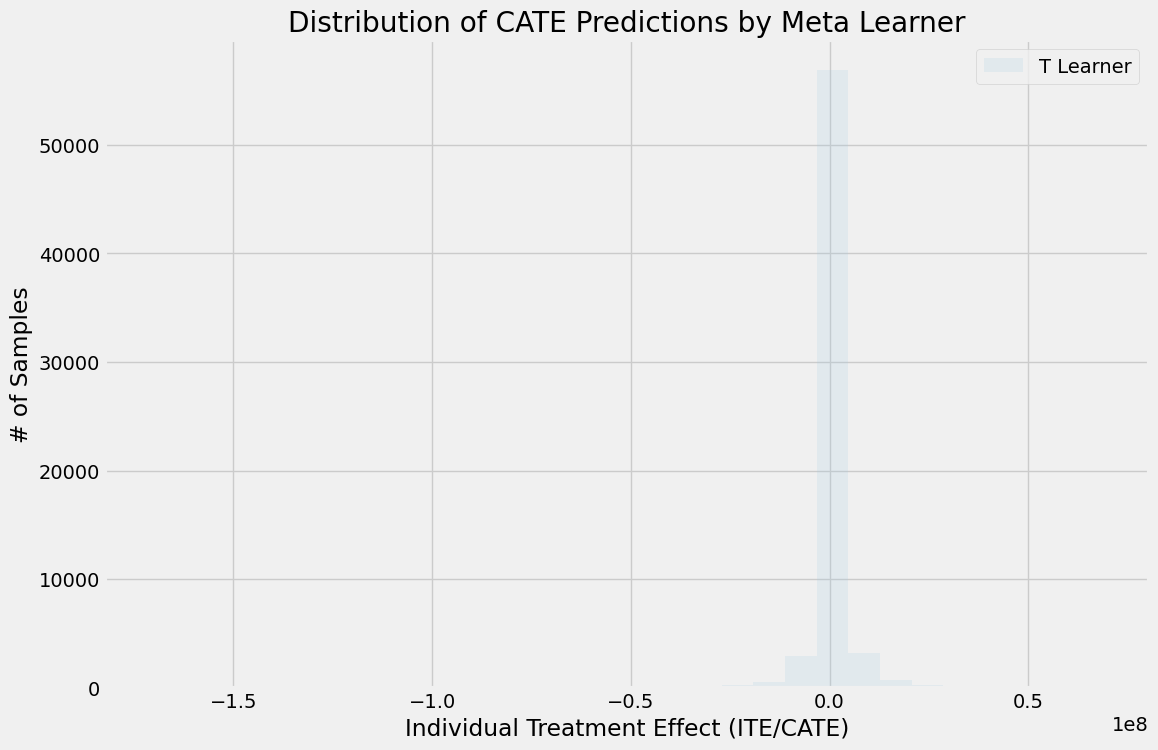

In [10]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
#plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
#plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
#plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
#plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
#plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
#           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

In [11]:
slearner = BaseSRegressor(XGBRegressor(), control_name=0)
slearner.estimate_ate(X, treatment, y)

array([89204.87637035])

In [12]:
slearner_tau = slearner.fit_predict(X, treatment, y)

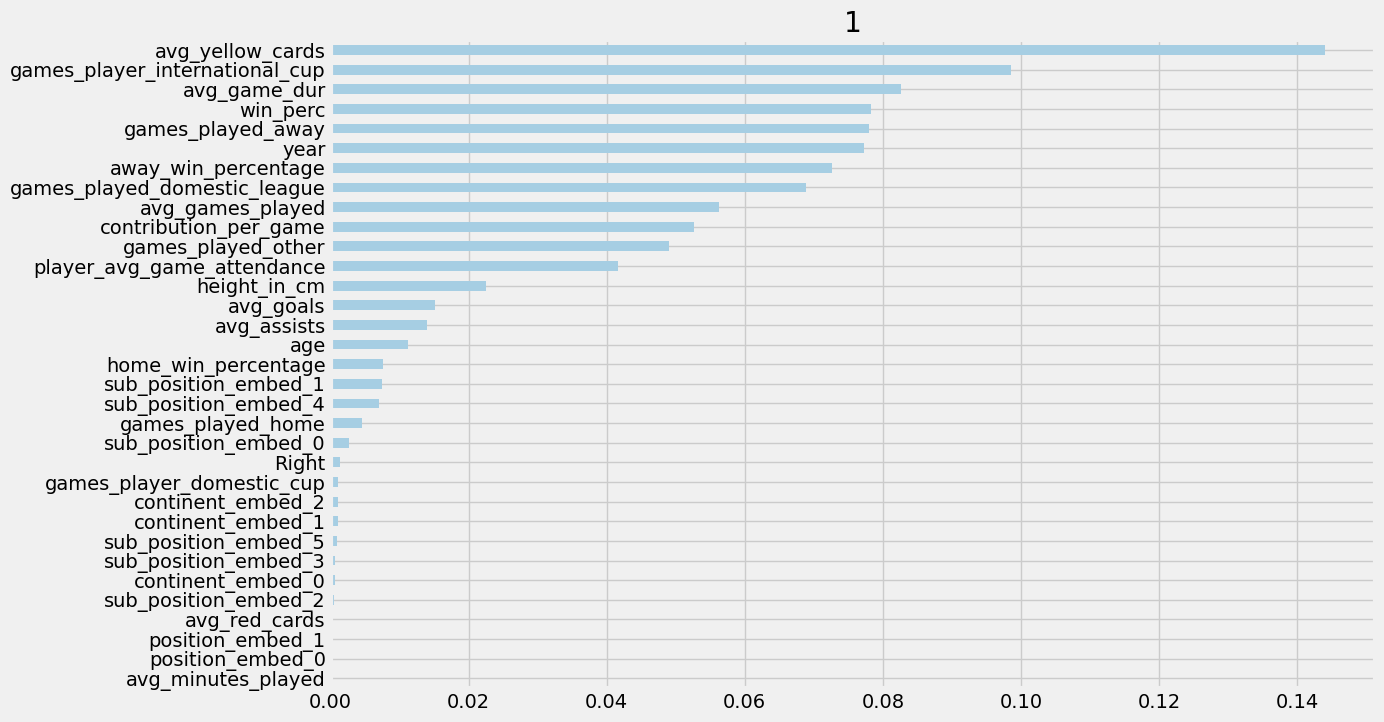

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)

In [14]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)

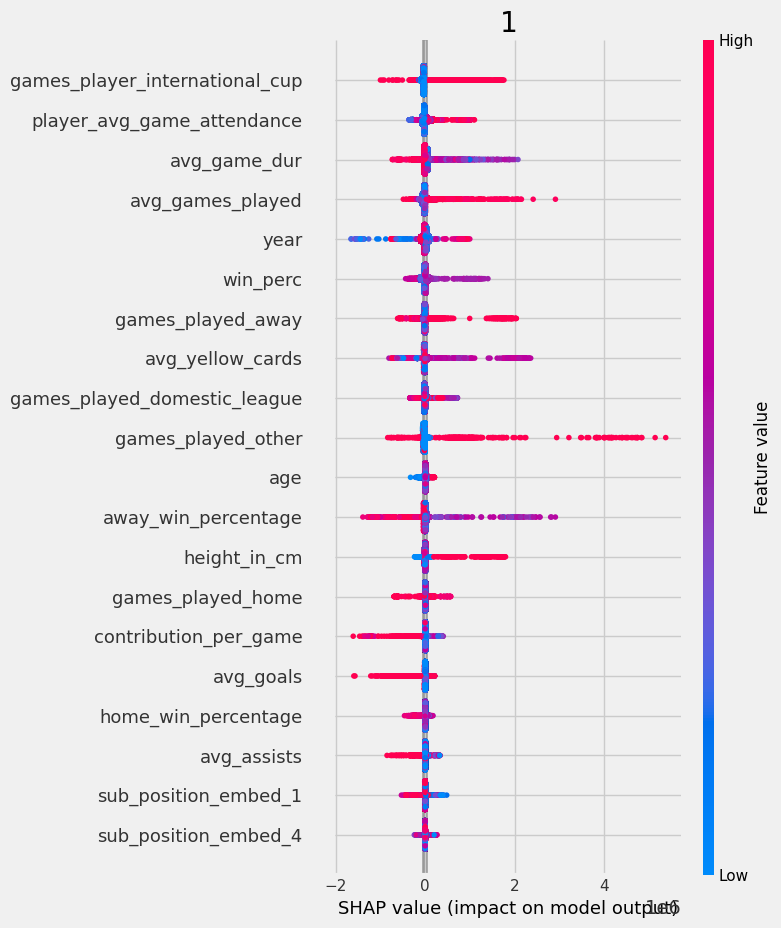

In [15]:
slearner.plot_shap_values(X=X, tau=slearner_tau, features=X.columns)

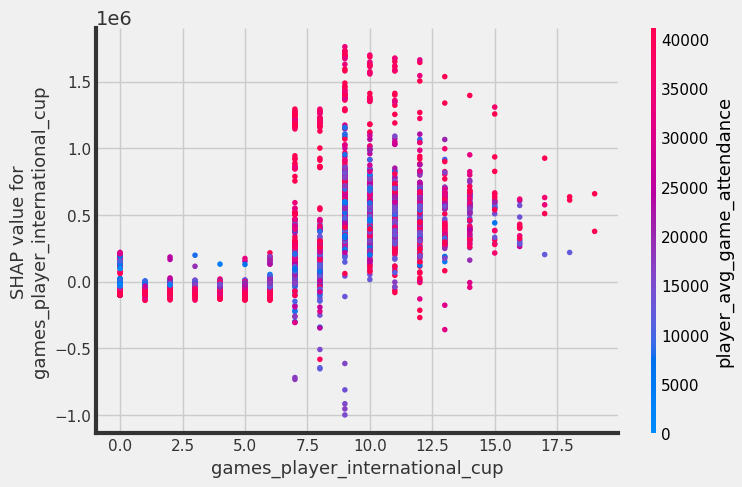

In [27]:
slearner.plot_shap_dependence(treatment_group=1,
                              feature_idx='games_player_international_cup',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=X.columns)

T Learner

In [17]:
tlearner = BaseTRegressor(XGBRegressor(), control_name=0)
tlearner.estimate_ate(X, treatment, y)

(array([153288.5297792]), array([103713.28607896]), array([202863.77347944]))

In [18]:
tlearner_tau = tlearner.fit_predict(X, treatment, y)

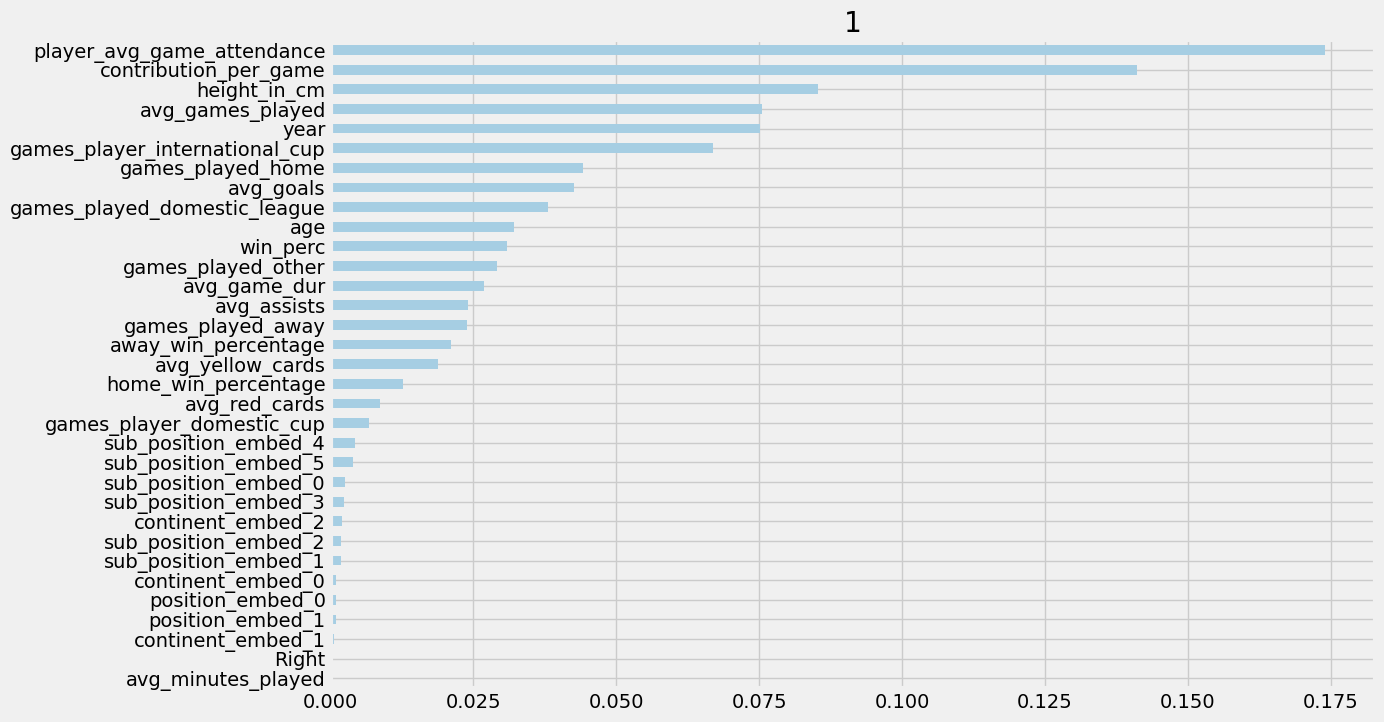

In [19]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)

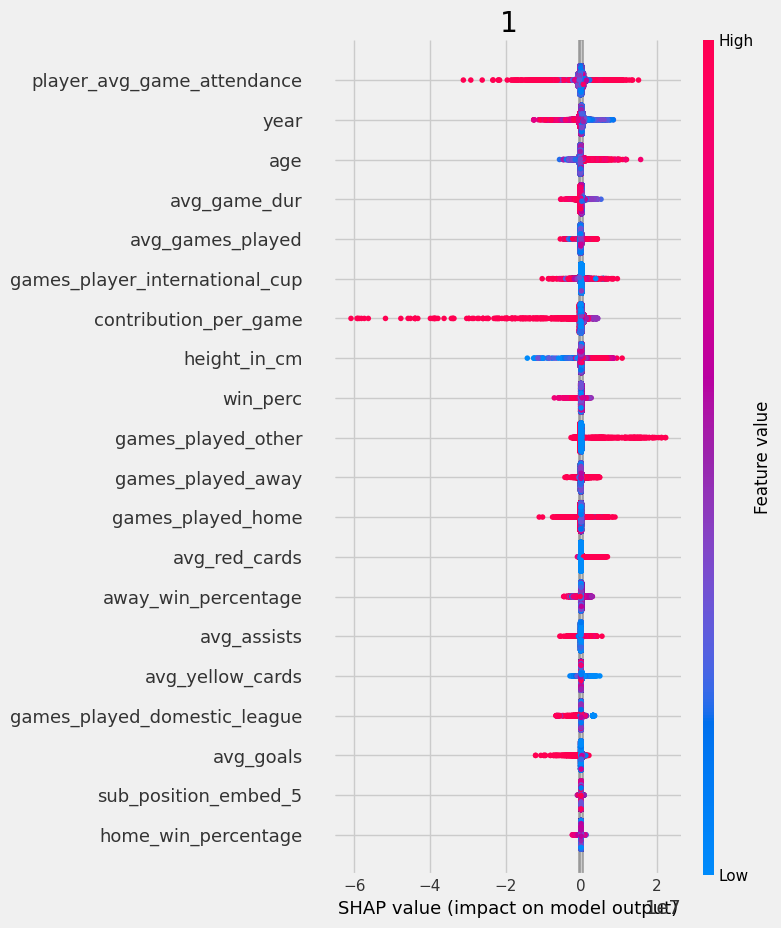

In [20]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=X.columns)

In [21]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)

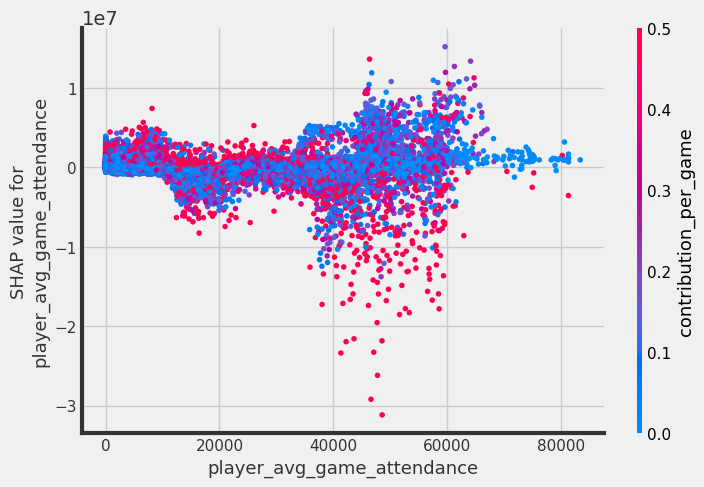

In [28]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
tlearner.plot_shap_dependence(treatment_group=1,
                              feature_idx='player_avg_game_attendance',
                              X=X,
                              tau=tlearner_tau,
                              interaction_idx='contribution_per_game',
                              shap_dict=shap_tlearner,
                              features=X.columns)